# PROJETO: PREDIÇÃO DE VENDAS DAS LOJAS ROSSMANN

## Contexto: 
    A rede Rossmann opera mais de 3.000 farmácias em 7 países europeus. Atualmente, os gerentes das lojas Rossmann têm a tarefa de prever suas vendas diárias com até seis semanas de antecedência. As vendas das lojas são influenciadas por muitos fatores, incluindo promoções, competição, férias escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

## Dados: 
    Os dados para esse projeto são publicos e disponibilizados na plataforma Kaggle, no endereço: https://www.kaggle.com/competitions/rossmann-store-sales/overview


### Descrição dos dados: 

Os dados fornecidos contemplam o histórico de vendas de 1.115 lojas da rede Rossmann. O objetivo é prever a coluna "Vendas" para o conjunto de teste.

Arquivos:

    train.csv - dados históricos, incluindo as vendas

    test.csv - dados históricos, excluindo as vendas

    store.csv - informações complementares sobre as lojas

Campos de Dados:

    Id - um Id que representa um par (Loja, Data) dentro do conjunto de teste;

    Store - um Id único para cada loja;

    Sales - o faturamento para um determinado dia (isso é o que você está prevendo);

    Customers - o número de clientes em um determinado dia;

    Open - um indicador se a loja estava aberta: 0 = fechada, 1 = aberta;

    StateHoliday - indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas nos feriados estaduais.
    Observe que todas as escolas estão fechadas nos feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal,
    0 = Nenhum;

    SchoolHoliday - indica se (Loja, Data) foi afetado pelo fechamento das escolas públicas;

    StoreType - diferencia entre 4 modelos diferentes de lojas: a, b, c, d;

    Assortment - descreve o nível de sortimento: a = básico, b = extra, c = estendido;

    CompetitionDistance - distância em metros até a loja concorrente mais próxima;

    CompetitionOpenSince[Month/Year] - indica o ano e o mês aproximados em que o concorrente mais próximo foi aberto;

    Promo - indica se a loja está fazendo uma promoção naquele dia;

    Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando;

    Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2;
            
    PromoInterval - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é iniciada novamente. 
    Por exemplo, "Feb, May, Aug, Nov" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.

## Métodologia: 

Este projeto foi feito seguindo o modelo CRISP-DS, ilustrado na figura abaixo:

![alt text](/home/mayconr/repos/ComunidadeDS/dsproducao/rossmann_project/images/CRISPDS.jpg "CRISP-DS")

# 0.0 IMPORTS

    Bibliotecas utilizadas


In [32]:
import os
import json
import math
import numpy                as np
import pickle
import random
import pandas               as pd
import xgboost              as xgb
import seaborn              as sns
import requests
import inflection
import matplotlib.pyplot    as plt

from scipy                      import stats    as ss
from boruta                     import BorutaPy
from datetime                   import datetime, timedelta
from IPython.display            import Image
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.ensemble           import RandomForestRegressor
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection    import train_test_split

## 0.1 FUNÇÕES AUXILIARES
    
    Funções utilizadas

In [33]:
def is_promo(row):
    if row['promo_interval'] == 0:
        return 0
    elif row['month_map'] in row['promo_interval'].split(','):
        return 1
    else:
        return 0

def cramer_v (x,y):

    cm = pd.crosstab(x, y).to_numpy()
    n=cm.sum()
    r,k=cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    v = np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    
    return v

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y,yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE':rmse,
                         'R2': r2}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max()-timedelta(days=6*7*(k))
        validation_end_date = x_training['date'].max()-timedelta(days=6*7*(k-1))

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        #
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']


        m = model.fit(xtraining, ytraining)

        yhat = m.predict(xvalidation)

        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        r2_list.append(m_result['R2'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + '+/-' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str),
                         'R2 CV': np.round(np.mean(r2_list),2).astype(str) + '+/-' + np.round(np.std(r2_list),2).astype(str)}, index=[0])

## 0.2 DIRETÓRIOS/CARREGAMENTO DOS DADOS

    Definição dos diretórios e leitura dos dados.


In [34]:
BASE_DIR = os.path.abspath('')   
DATA_DIR = os.path.join(BASE_DIR,'data')
PARA_DIR = os.path.join(BASE_DIR,'parameter')

df_sales_raw = pd.read_csv(os.path.join(DATA_DIR,'train.csv'), low_memory = False)
df_store_raw = pd.read_csv(os.path.join(DATA_DIR,'store.csv'), low_memory = False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df1 = df_raw.copy()

# 1.0 DESCRIÇÃO DOS DADOS

    Verificações e modificações básicas no dataframe



## 1.1 Renomeando colunas
    As colunas são reescritas no modo snake, todas minusculas e com _ no lugar de espaços

In [35]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Tipo e dimensões dos dados
    Dimensões do dataframe e os tipos de informações em cada colunas. Esse é uma verificação importante pois nos da noção da quantidade de dados que estamos trabalhando e se as dimensões das colunas estão corretas 

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))
df1.dtypes

## 1.3 Verificação e preenchimentos dos valores NaN
    Verificação das colunas e quantidade de linhas que possuem NaN. Esses valores faltantes são preenchidos com base na lógica do negócio

In [ ]:
print(df1.isna().sum())

### Preenchimento dos valores NaN
##### Todas presunções assumidass são baseadas nos meus conhecimentos em problemas de negócio e não necessáriamente refletem a realidade das lojas Rossmann

#### competition_distance
    Os valores não preenchidos nessa coluna provavelmte significam que essas lojas não possuem um competidor próximo, portanto, para preencher essas coluna utilizarei valores de distancias muito grandes, no caso 200000 metros.

#### competition_open_since_month
    Aqui temos o tempo, por mês, em que a ultima loja concorrente abriu. Os valores NaN se devem provavelmente por lojas não possuem competidor perto, ou que o competidor já existia no momento em que a loja da Rossmann foi inaugurada, ou ainda por simplesmente por falta de acesso a essa informação. Vamos considerar então a data da venda como essa data, dessa forma a diferença entre a data de venda e abertura será zero para os valores NaN.

#### competition_open_since_year // promo2_since_week // promo2_since_year
    Aplicaremos a mesma lógica do caso anterior

#### promo_interval
    0 se não houve promoção

Além disso também foi alterado os meses de números para seus nomes abreviados.



In [36]:
df1['date'] = pd.to_datetime(df1['date'])
# competition_distance
df1['competition_distance'].fillna(200000.0, inplace=True)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)


month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(is_promo, axis=1)

## 1.5 Alteração dos tipos de variavéis
    Transformação nos tipos de variaveis das colunas, se necessário

In [ ]:
df1.dtypes

In [37]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.6 Estatistica descritiva
    Analise estatistica descritiva das variaveis. Para as variaveis numericas foram tomadas medidas de tendencia central (média e mediana) e medidas de dispersão (desviopadrão, range, skewness e kurtosis). Para as váriaveis categóricas foi realizado um boxplot.

    Essa análise nos permite ter uma breve noção do comportamento dos dados com que estamos trabalhando

In [38]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [39]:
#Medidas de tendencia central - mmedia e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Medidas de dispersão - desvio padrão, min, max, range, skewness, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='assortment', ylabel='sales'>

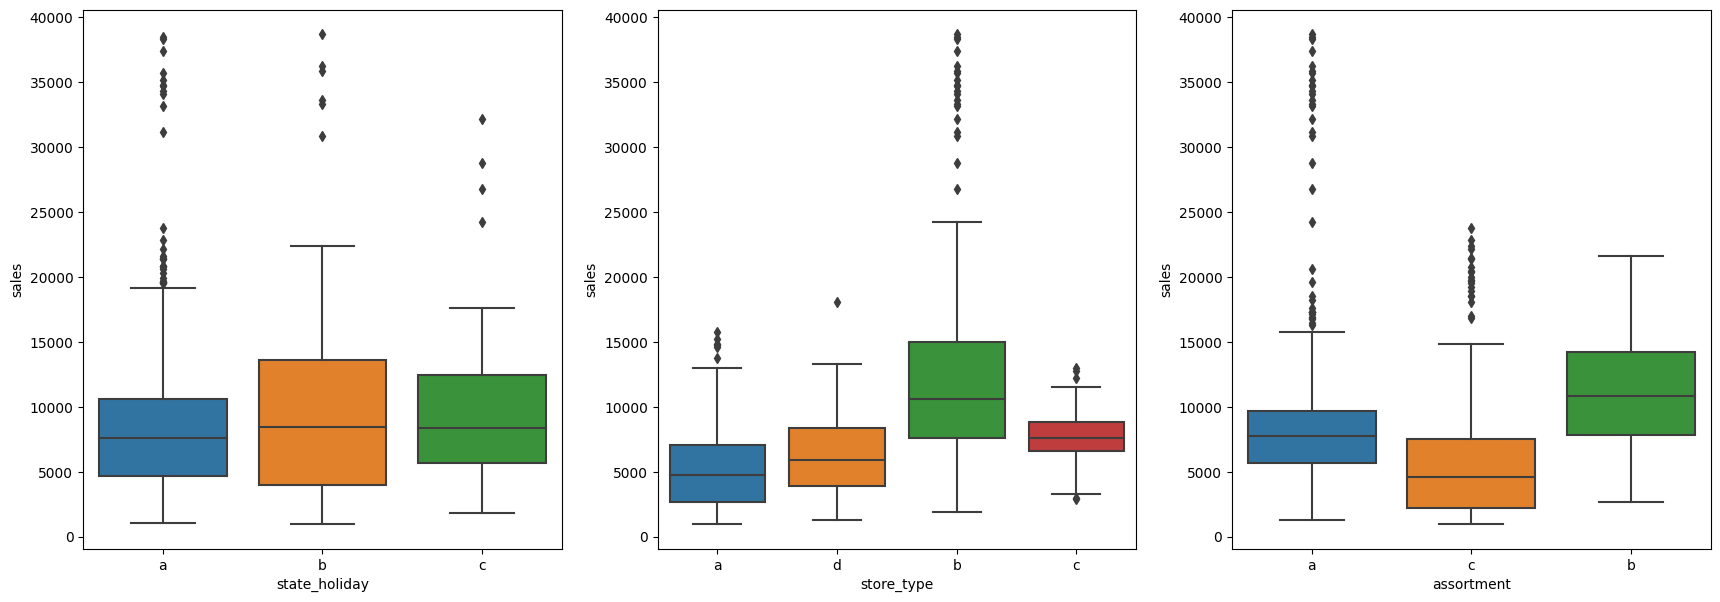

In [40]:
cat_attributes.apply(lambda x: x.unique().shape[0])

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig = plt.subplots(1, 3, figsize=(21, 7))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING


In [41]:
df2 = df1.copy()

## 2.1 Mapa mental das hipoteses
    Para dar inicio ao processo de feature engineering foi criado um mapa mental de hipoteses, onde, me baseando no problema de negócio estabelecido, criei diferentes hipoteses separadas por Lojas, Clientes, Produtos, Localização e Sazonalidade.

In [ ]:
Image('images/mind_map_hipoteses.png')

## 2.2 Criação das hipoteses


### hipoteses  loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais;

**2.** Lojas com maior estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com menor porte deveriam vender menos;

**5.** Lojas com maior sortimento deveriam vender mais;

**6.** Lojas com competidores mais próximos deveriam vender menos;

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### hipoteses do produto

**1.** Lojas que investem mais em marketing deveriam vender mais;

**2.** Lojas que expoem mais os produtos na vitrine deveriam vender mais;

**3.** Lojas que tem preços menores nos produtos deveriam vender mais;

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivais deveriam vender mais;

**6.** Lojas com mais dias de promoção deveriam vender mais;

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### hipoteses de tempo

**1.** Lojas que abrem durante o natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveria vender mais após o dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante feriados escolares;

### Lista final de hipoteses

    Nem todas hipóteses anteriores podem ser respondidas com o dataset disponibilizado, devido a isso seleceionei apenas algumas:

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores à mais tempo deveriam vender mais.

--------------------------------------------------------------------------------

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais;

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

--------------------------------------------------------------------------------

**7.** Lojas que abrem durante o natal deveriam vender mais;

**8.** Lojas deveriam vender mais ao longo dos anos;

**9.** Lojas deveriam vender mais no segundo semestre do ano;

**10.** Lojas deveria vender mais após o dia 10 de cada mês;

**11.** Lojas deveriam vender menos aos finais de semana;

**12.** Lojas deveriam vender menos durante feriados escolares;

## 2.3 Feature Engineering
    A partir de agora começa o processo de extração de novas variavéis a partir das disponiveis no dataframe. As variaveis derivadas abaixo são, respectivamente:
    - Ano
    - Mês
    - Dia
    - Semana do ano
    - Ano-Semana
    - Tempo de competição
    - Tempo de competição por mês
    - Tempo de promoção
    - Tempo de promoção por semana
    - Alteração nos valores de assortment/state_holiday para seus devidos significados

In [42]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition since
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x+'-1','%Y-%W-%w')-timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 FILTRAGEM DE VARIAVEIS

In [43]:
df3 = df2.copy()

## 3.1 Filtragem das linhas
    Linhas onde a loja estava fechada ou com vendas iguais a zero não serão úteis para a modelagem. Tiramos elas a seguir.

In [44]:
df3 = df3[df3['open'] != 0]
df3 = df3[df3['sales'] > 0]

## 3.2 Seleção das colunas
    Agora também selecionamos as colunas que não agregam informação para o modelo.

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANALISE EXPLORATORIA DOS DADOS
    Inicio da analise exploratória. Separamos novamente as variaveis em categoricas e numericas

In [46]:
df4 = df3.copy()
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Analise univariada
    Analise univariada nas variaveis resposta, númericas e categóricas

### 4.1.1 Variavel resposta

    No primeiro gráfico abaixo temos a distribuição da varavel resposta "Sales", vemos que sua distribuição não é exatamente uma normal pois apresenta uma skewness positiva, como indicado pela tabela obtida na seção 1.6. Em geral os algoritmos de Machine Learning apresentam um melhor resultado com distribuição normal, podemos então transformar a variavel resposta aplicando uma função ln(x) (será feito mais a frente), obtendo assim uma distribuição mais fiel a uma normal, como mostrado na segunda figura.

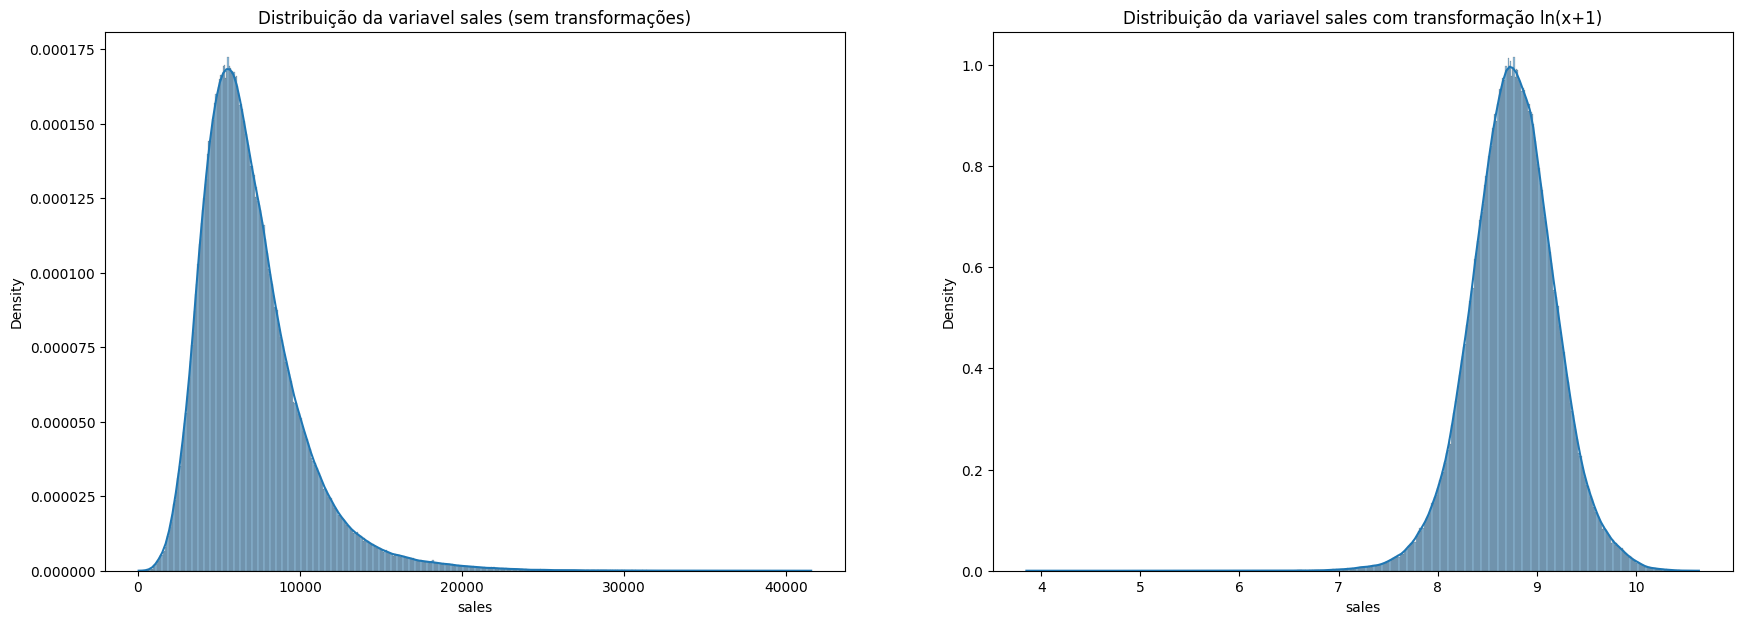

In [47]:
#Variavel resposta
fig = plt.subplots(1,2,figsize=(21,7))

plt.subplot(1,2,1)
sns.histplot(df4['sales'], kde=True, stat="density"); plt.title('Distribuição da variavel sales (sem transformações)');
plt.subplot(1,2,2)
sns.histplot(np.log1p(df4['sales']), kde=True, stat="density"); plt.title('Distribuição da variavel sales com transformação ln(x+1)');

### 4.1.2 Variaveis númericas

    Podemos notar nos histogramas abaixo que não temos váriavéis númericas que apresentam um distribuição caracteristica, exceto pela váriavel sales, essa porém é a nossa variavél resposta. Isso implica na impossibilidade de aplicar métodos de normalização posteriormente, nos restando utilizar métodos de reescala.

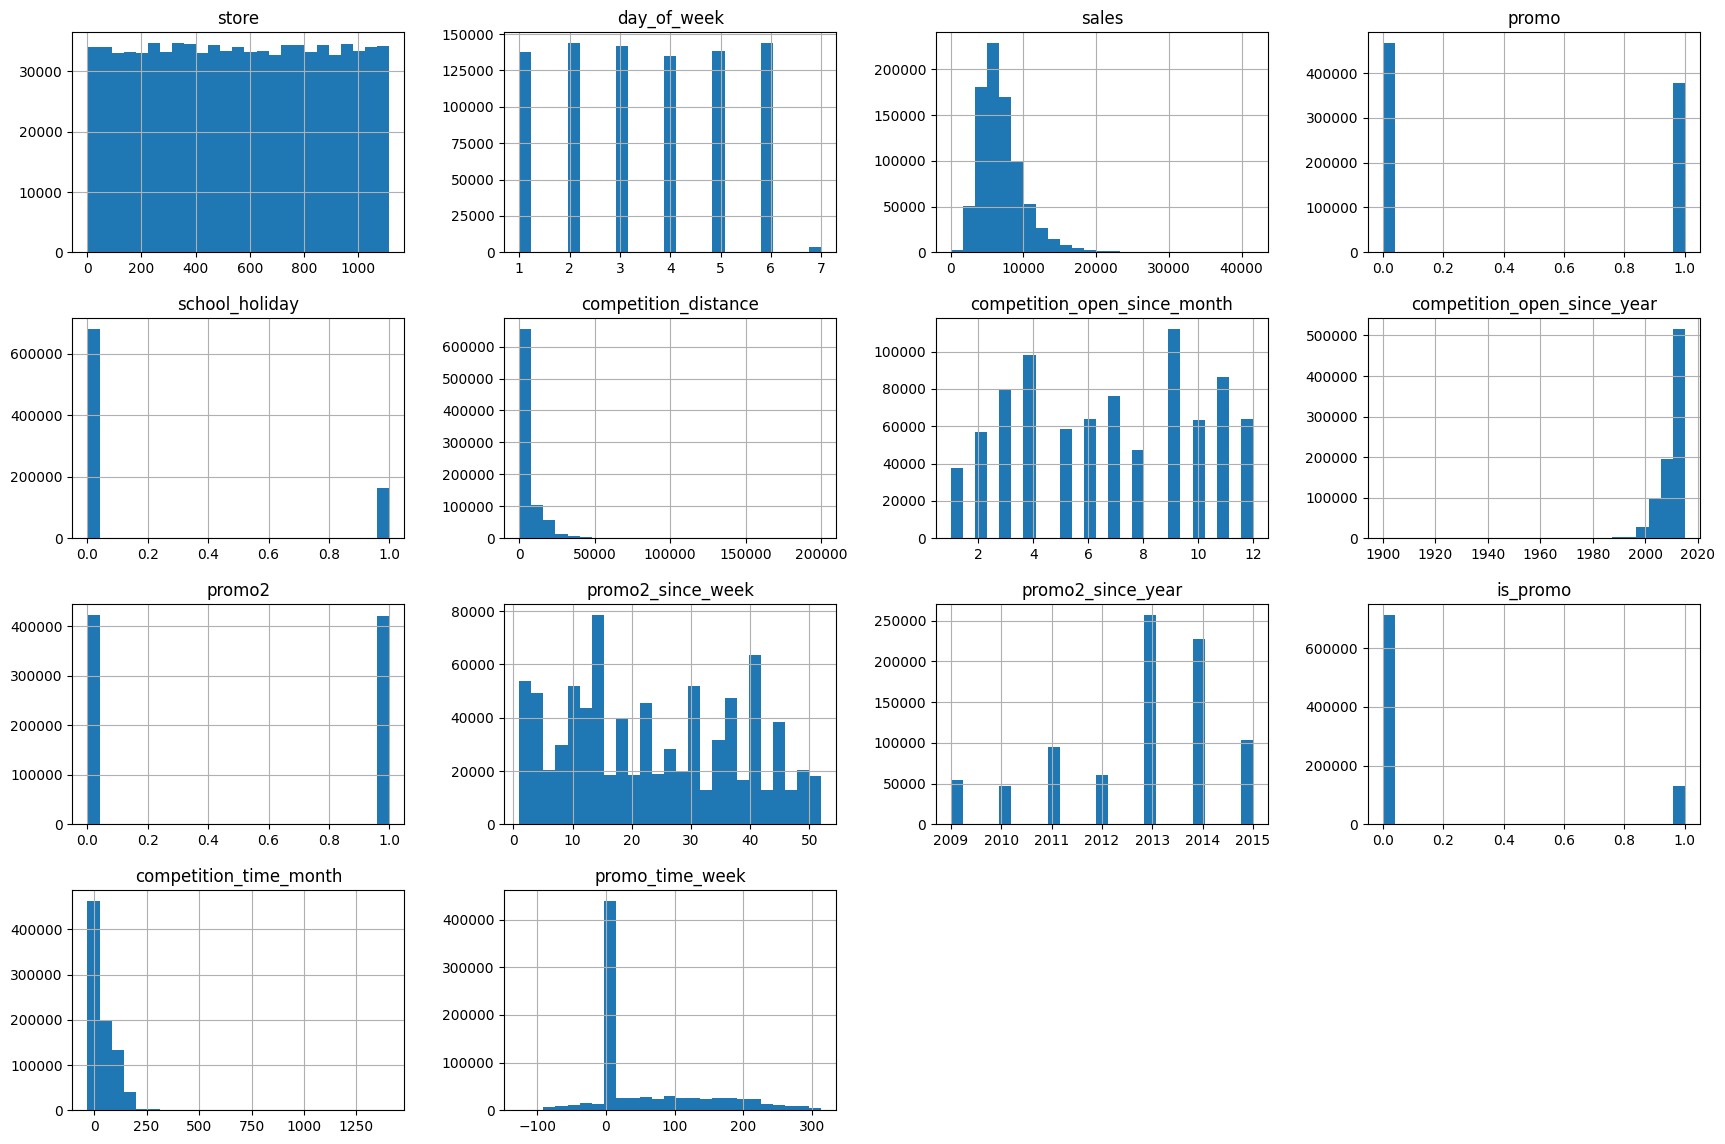

In [48]:
num_attributes.hist(bins=25, figsize=(21,14));

### 4.1.3 Variaveis categoricas

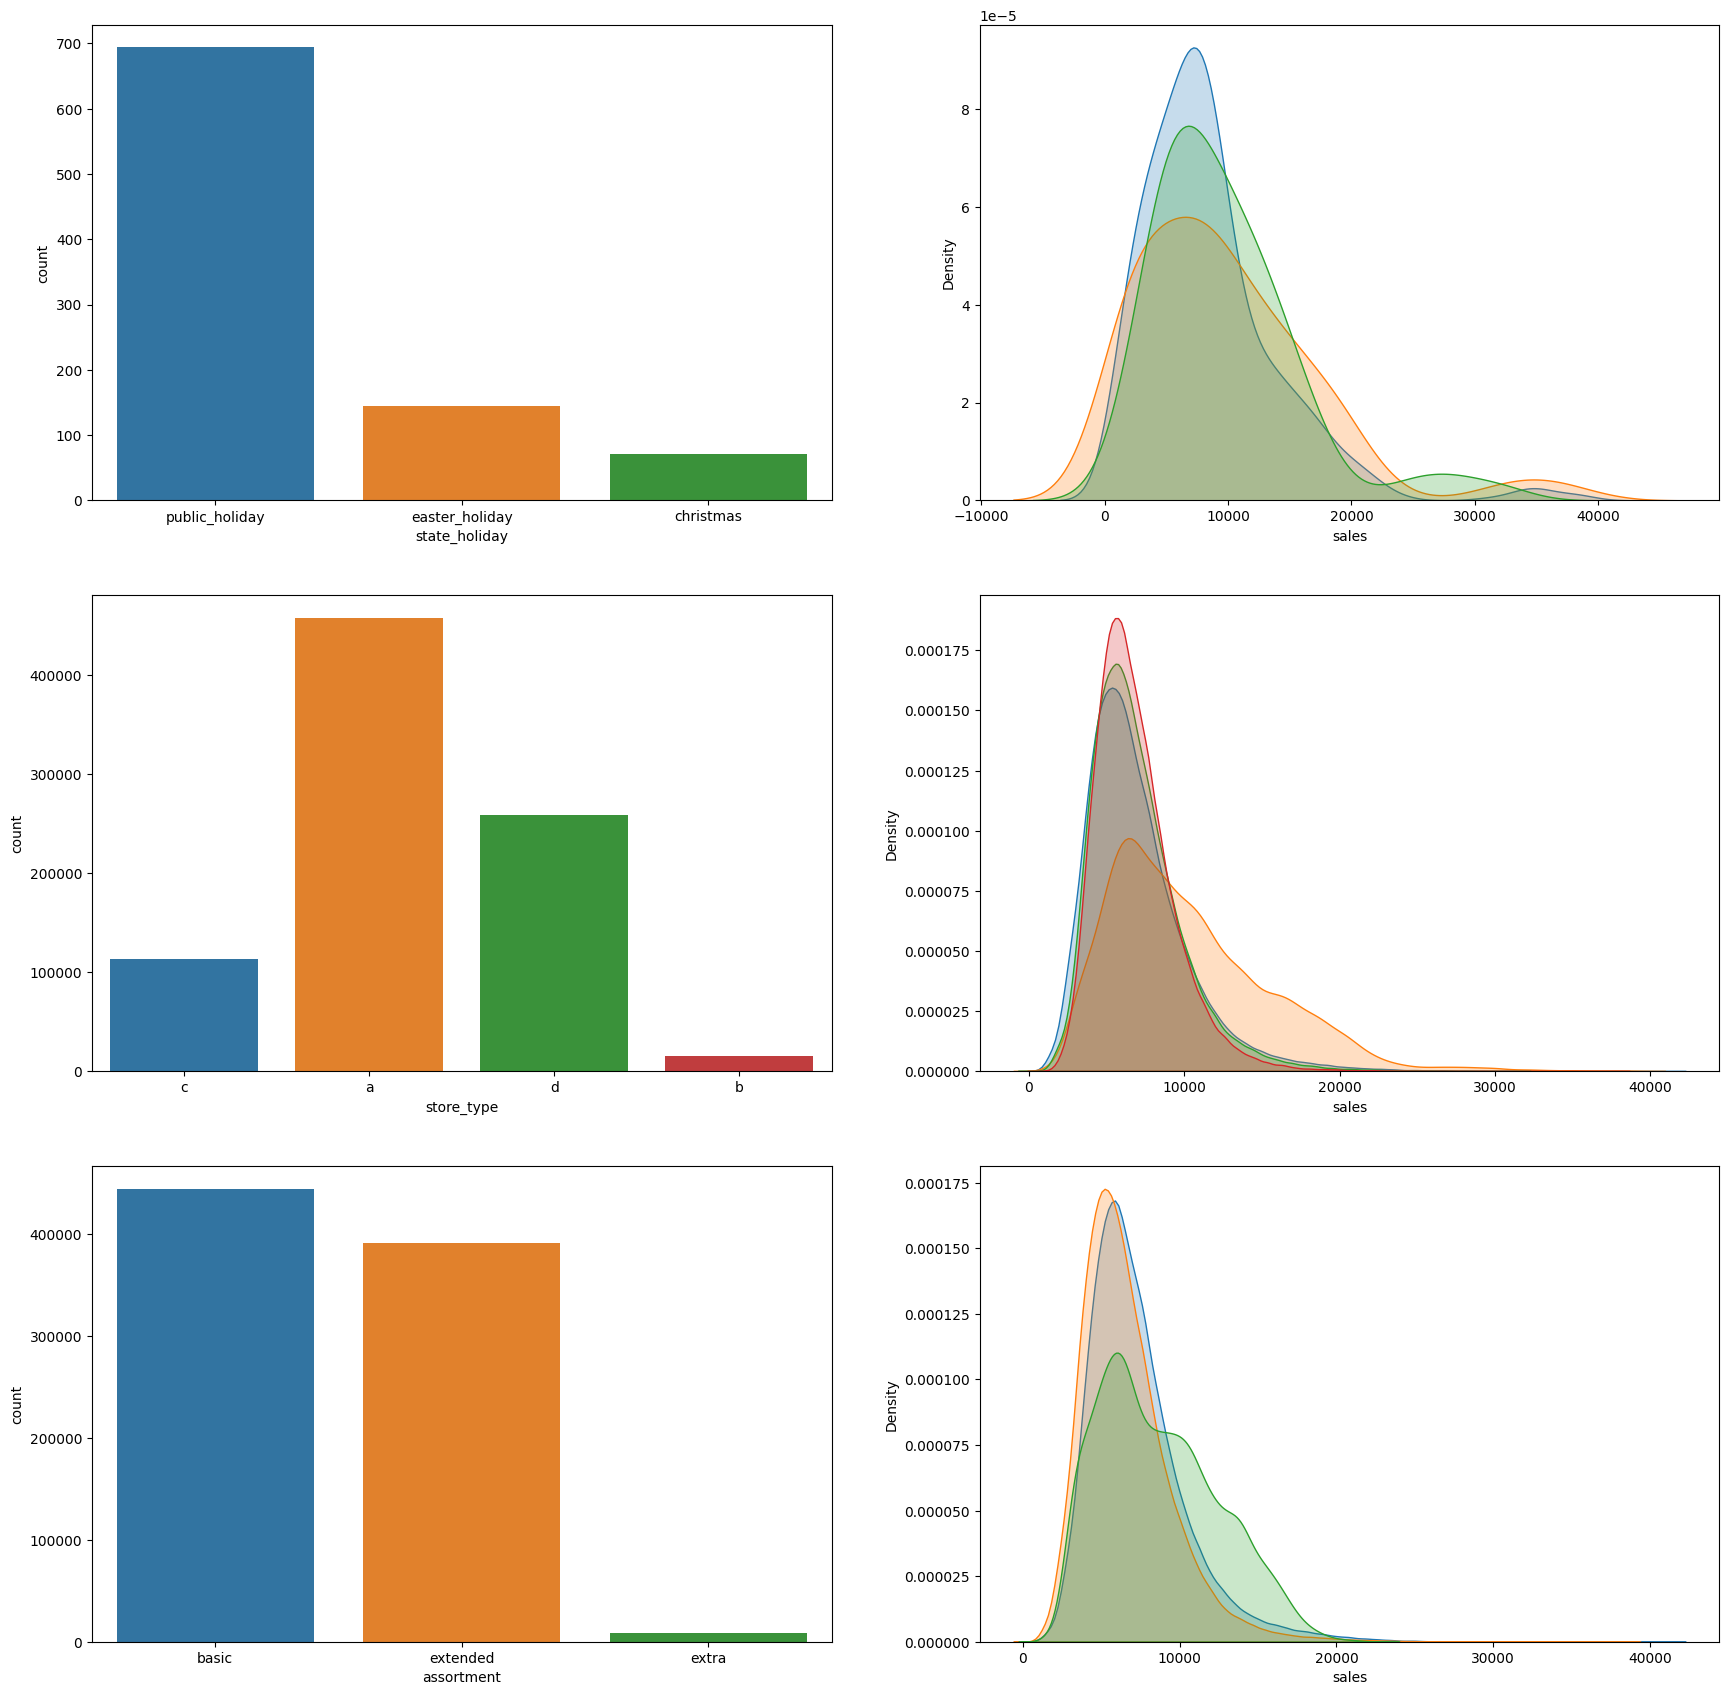

In [49]:
#state holiday
a=df4[df4['state_holiday'] != 'regular_day']
fig = plt.subplots(3,2,figsize=(21,21))
plt.subplot(3,2,1)
sns.countplot(a,x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True);


#store_type
plt.subplot(3,2,3)
sns.countplot(df4,x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True);

#assortment
plt.subplot(3,2,5)
sns.countplot(df4,x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True);


## 4.2 Analise bivariada
    Aqui foi verificado se as hipoteses criadas anteriormente são verdadeiras ou falsas.

### H1 lojas com mais sortimento deveriam vender mais

***FALSO*** Na verdade lojas com maior sortimento vende menos


<Axes: xlabel='year_week'>

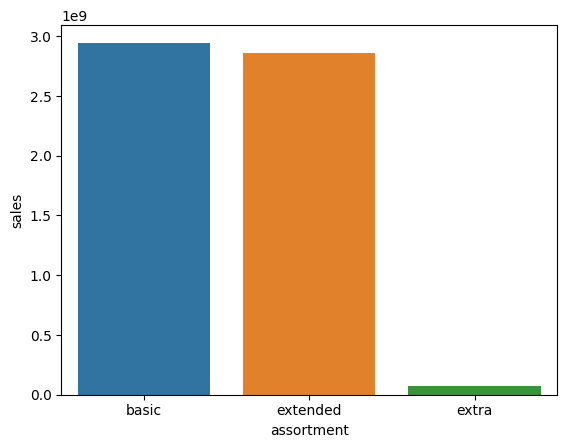

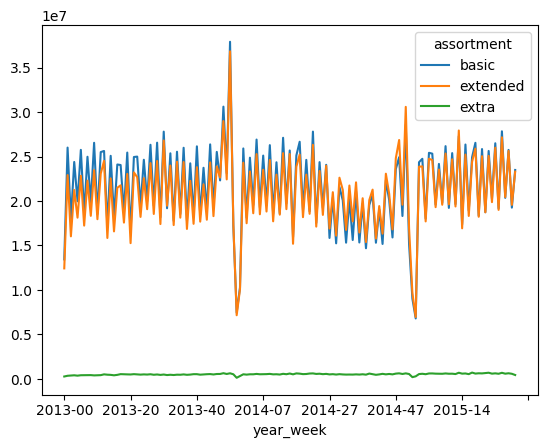

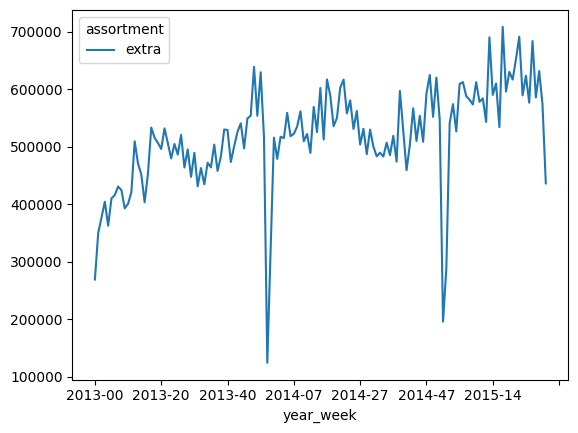

In [50]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


### H2 lojas com competidores mais próximos deveriam vender menos
***FALSO*** Loja com competidores próximos vendem mais e não menos

/tmp/ipykernel_13104/102527474.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1);


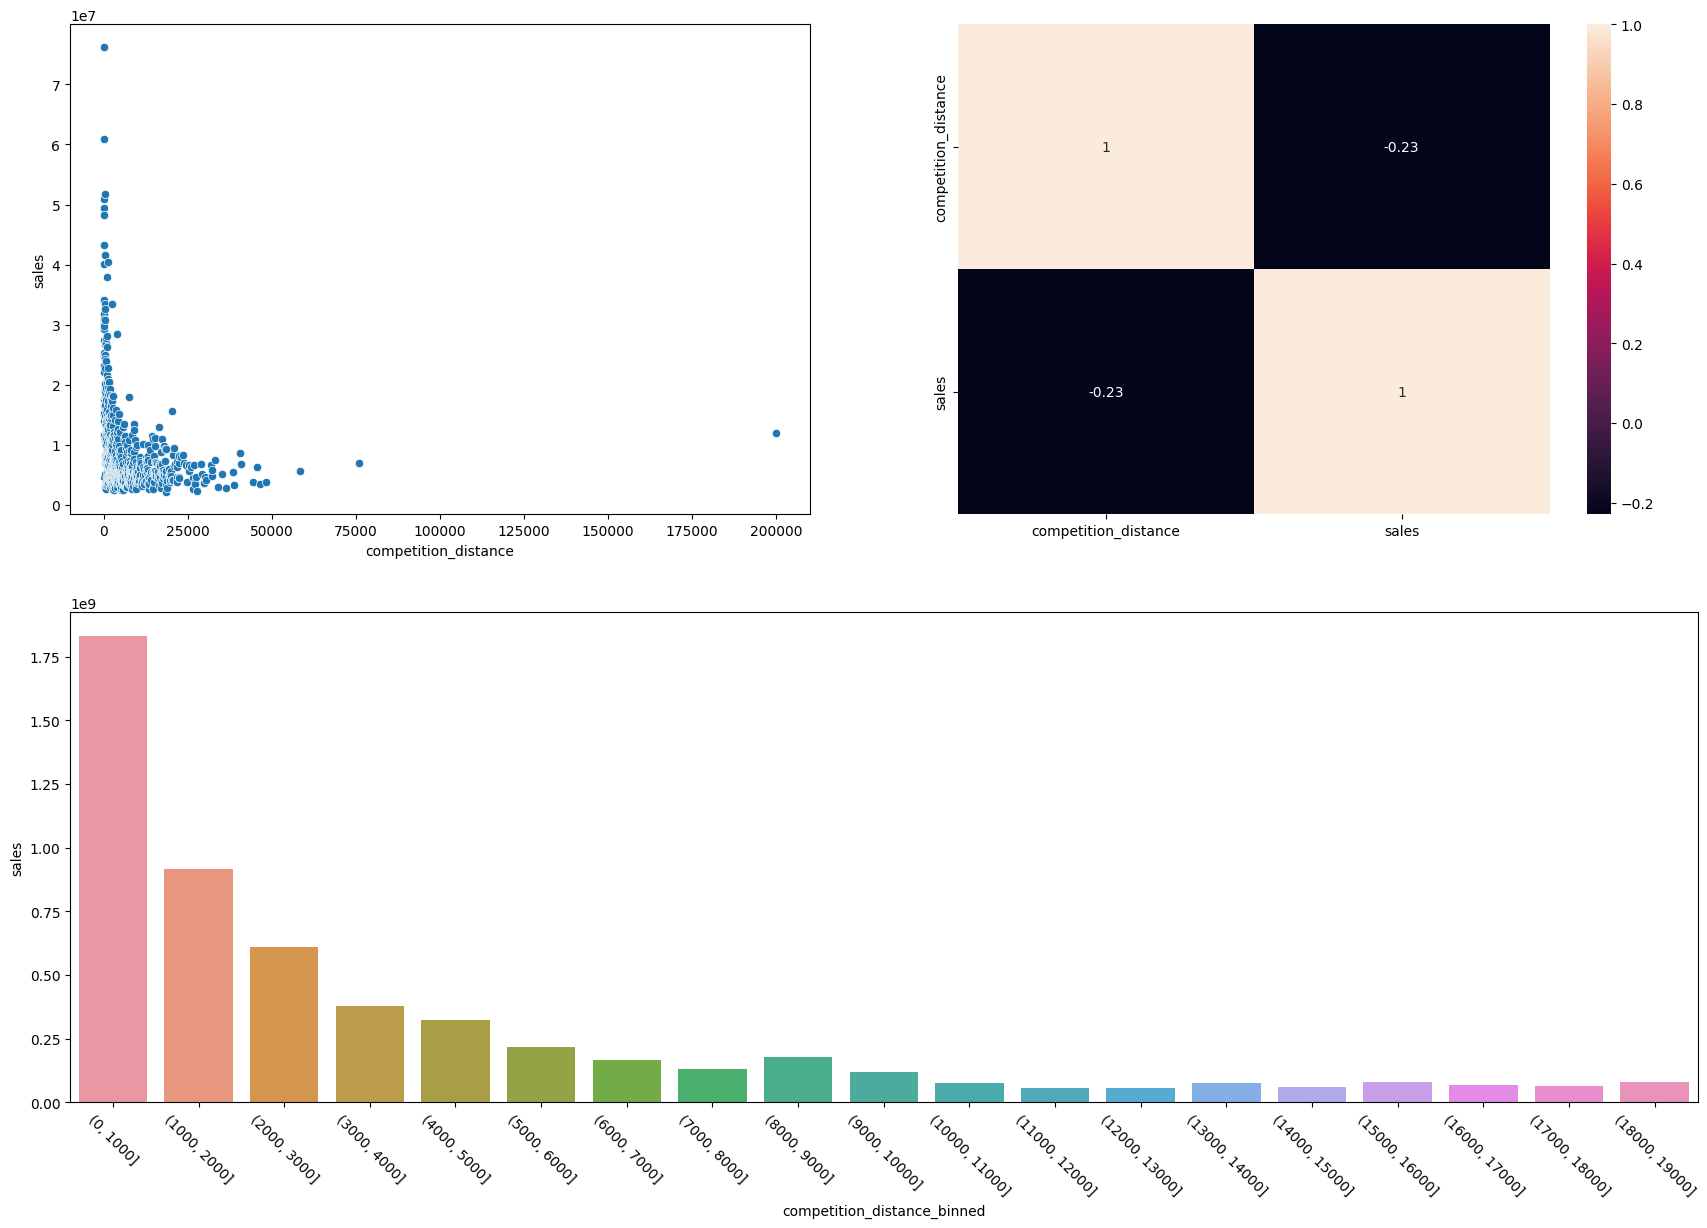

In [51]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))

fig = plt.subplots(figsize=(21,14));
plt.subplot(2,2,1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(2,2,2);
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()


plt.subplot(2,2,(3,4));
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=-45);



### H3 loja com competidores a mais tempo deveriam vender mais
***FALSO*** loja com competidores a mais tempo vendem menos

/tmp/ipykernel_13104/1673178285.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,(3,4))


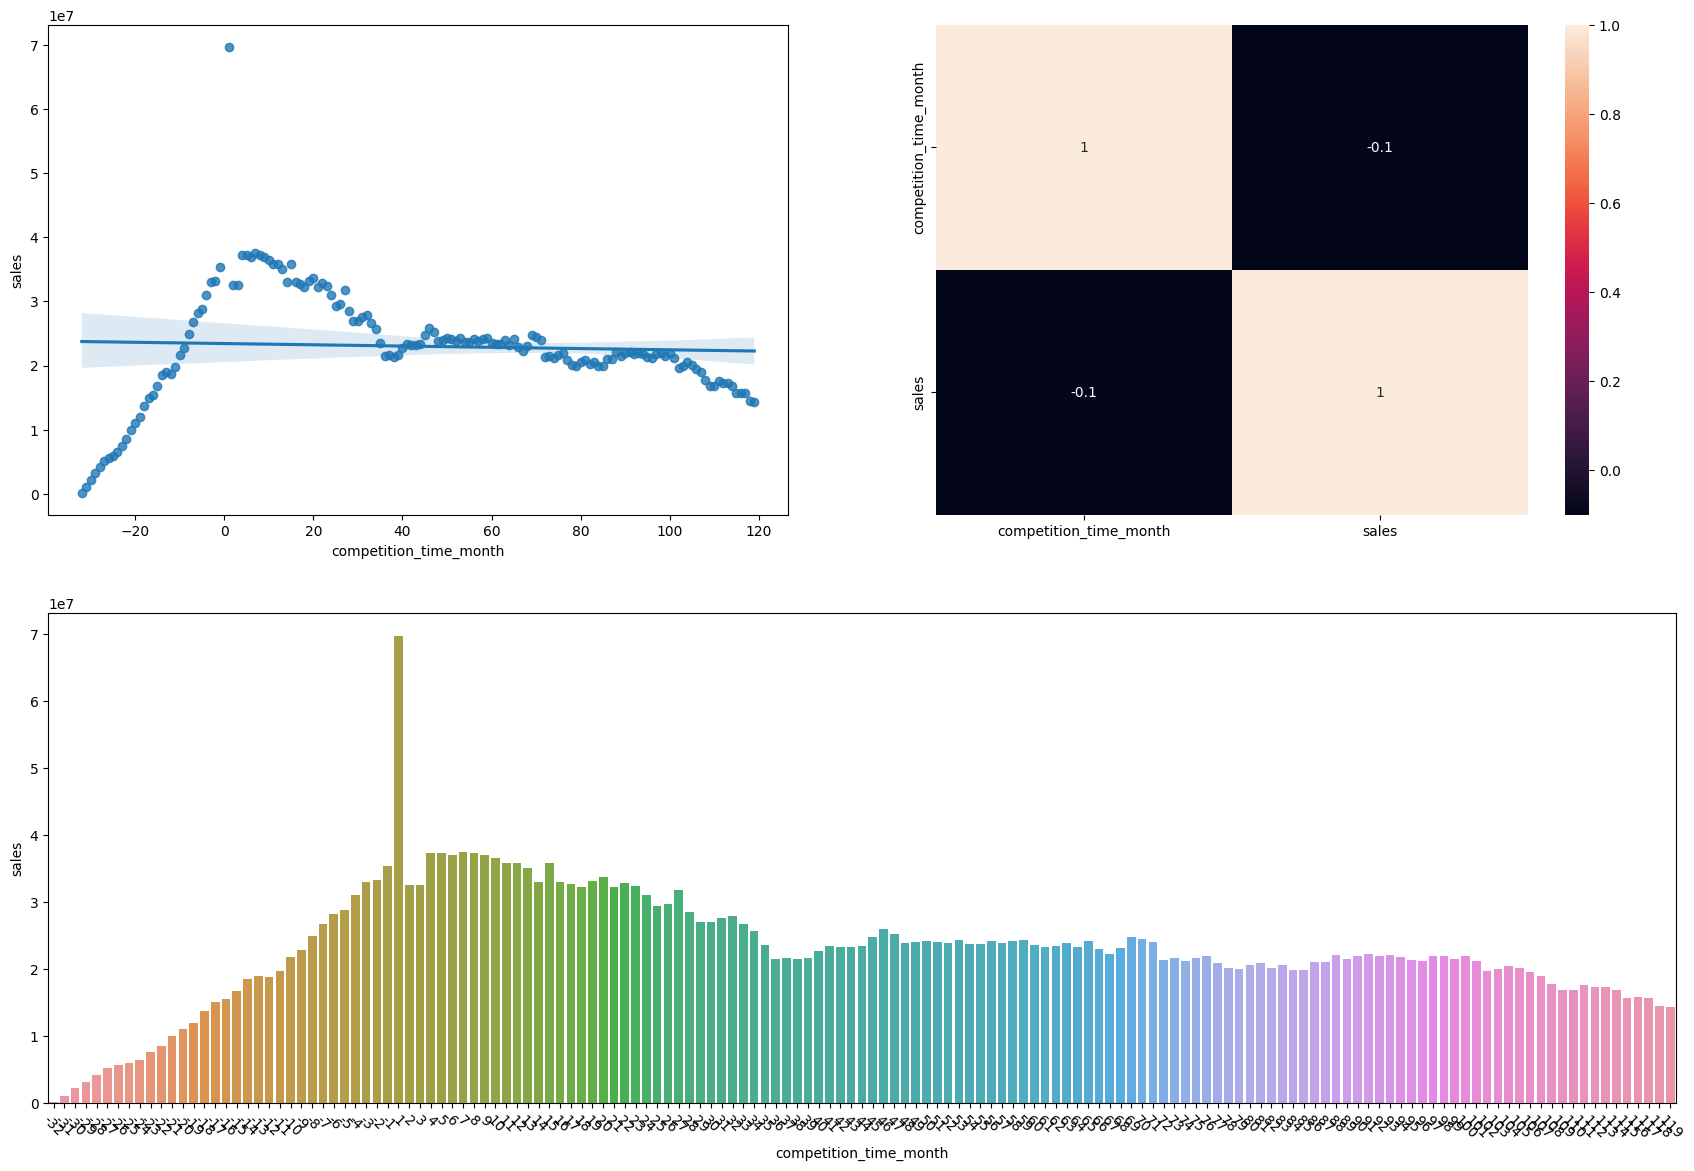

In [52]:
plt.subplots(2,2,figsize=(21,14))

aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[aux1['competition_time_month']<120]
aux2 = aux2[aux2['competition_time_month'] != 0]


plt.subplot(2,2,1)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,(3,4))
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=-45);


### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.

***FALSO*** Ela vende regularmente por um periodo, porém tempo depois passa a cair

/tmp/ipykernel_13104/2770819741.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,(3,6))


<Axes: >

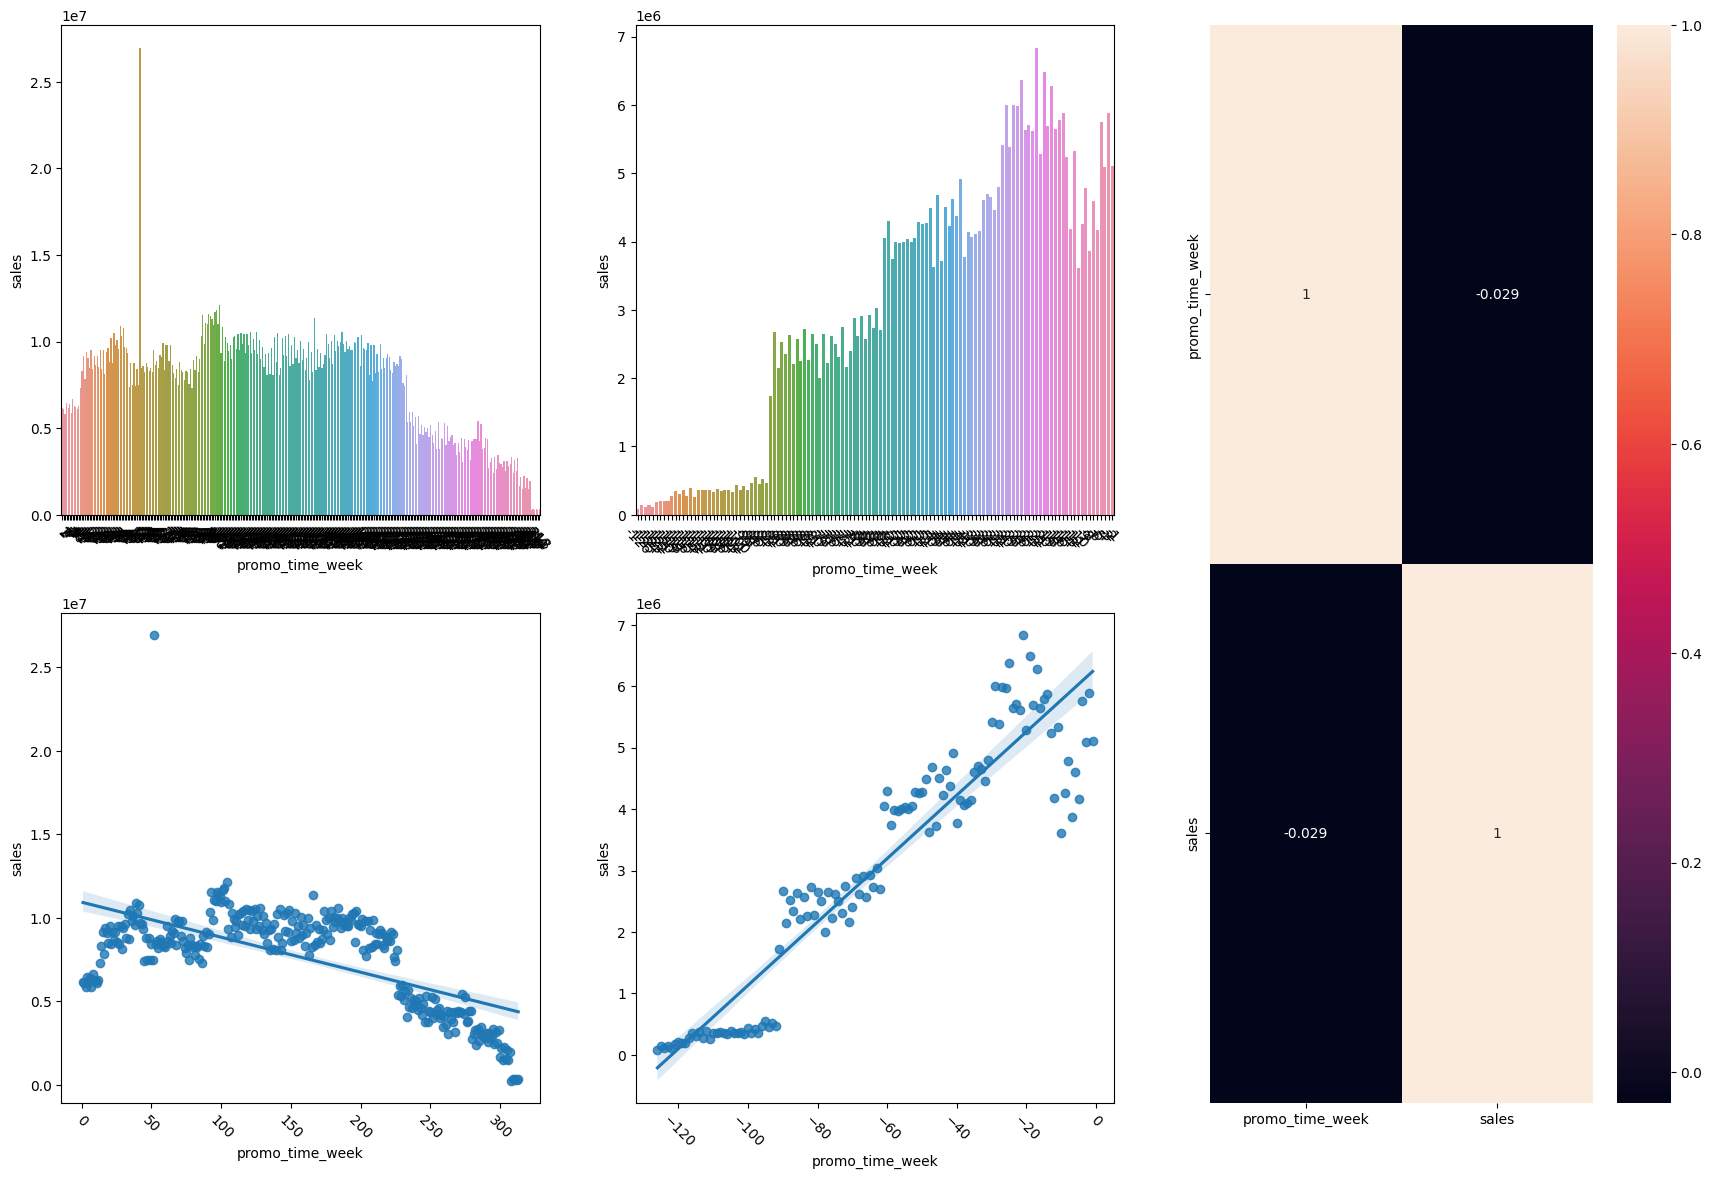

In [53]:

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week']>0] #periodo extendido
aux3 = aux1[aux1['promo_time_week']<0] #periodo regular

fig = plt.subplots(2,3,figsize=(21,14))
plt.subplot(2,3,1)
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=-45);

plt.subplot(2,3,4)
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=-45);

plt.subplot(2,3,2)
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=-45);

plt.subplot(2,3,5)
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=-45);

plt.subplot(2,3,(3,6))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>H5 Lojas com mais dias de promoção deveriam vender mais</s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais

***FALSO*** Lojas com mais promo consec, vendem menos

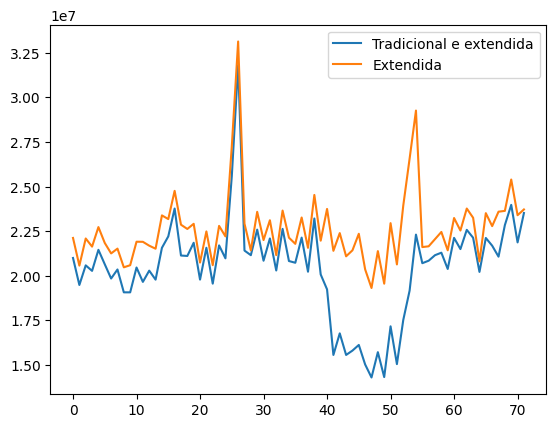

In [54]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()


aux1 = df4[df4['promo'] == 1]
aux1 = aux1[aux1['promo2'] == 1][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[df4['promo'] == 1]
aux2 = aux2[aux2['promo2'] == 0][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e extendida', 'Extendida'])

### H7 Lojas abertas durante o feriado de Natal deveriam vender mais do que em outros feriados

***FALSO*** Lojas abertas durante o feriado de natal vendem menos quando comparado com o feriado de páscoa

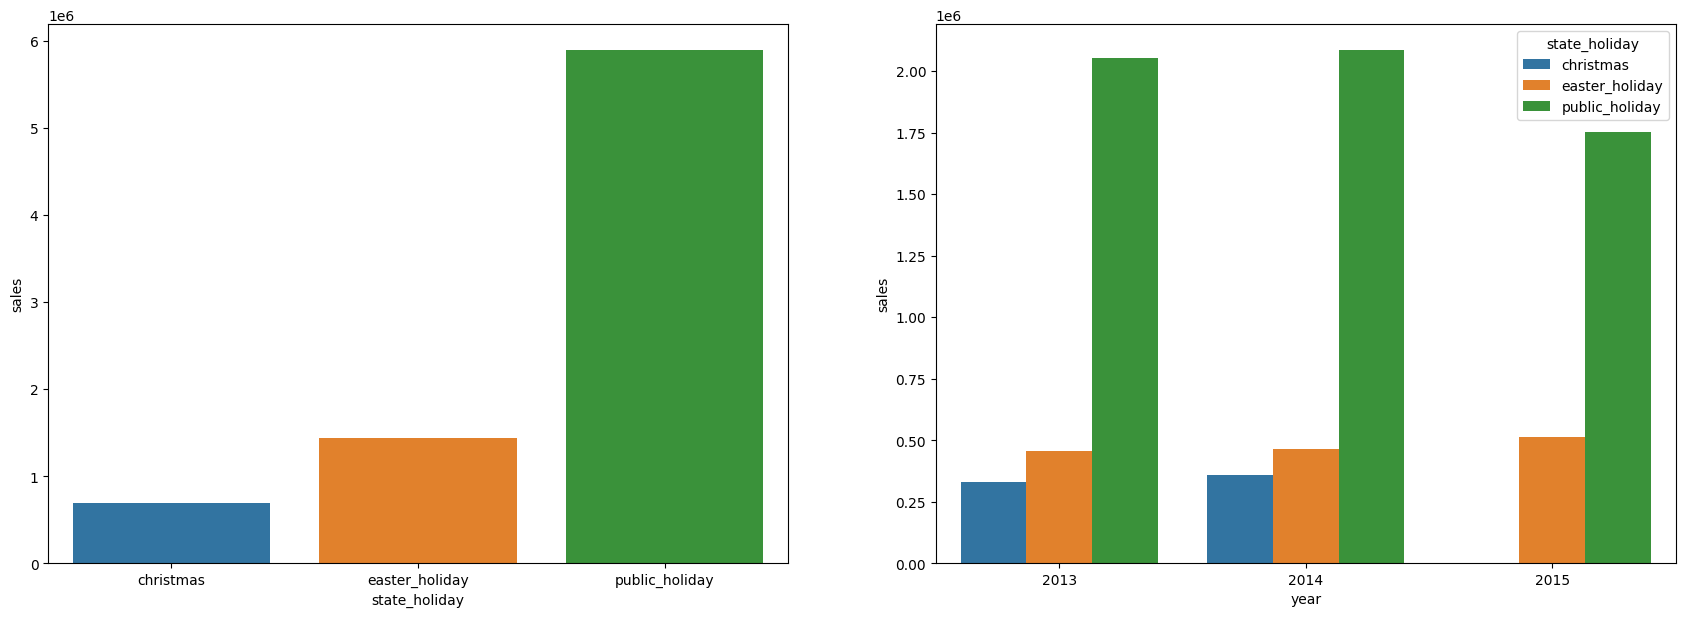

In [55]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig=plt.subplots(1,2,figsize=(21,7))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#sns.countplot(x=aux['state_holiday'])

### H8 Lojas deveriam vender mais ao longo dos anos

***FALSO*** Falso, porém temos apenas dois anos para comparar (já que 2015 ainda não esta completo no dataset).


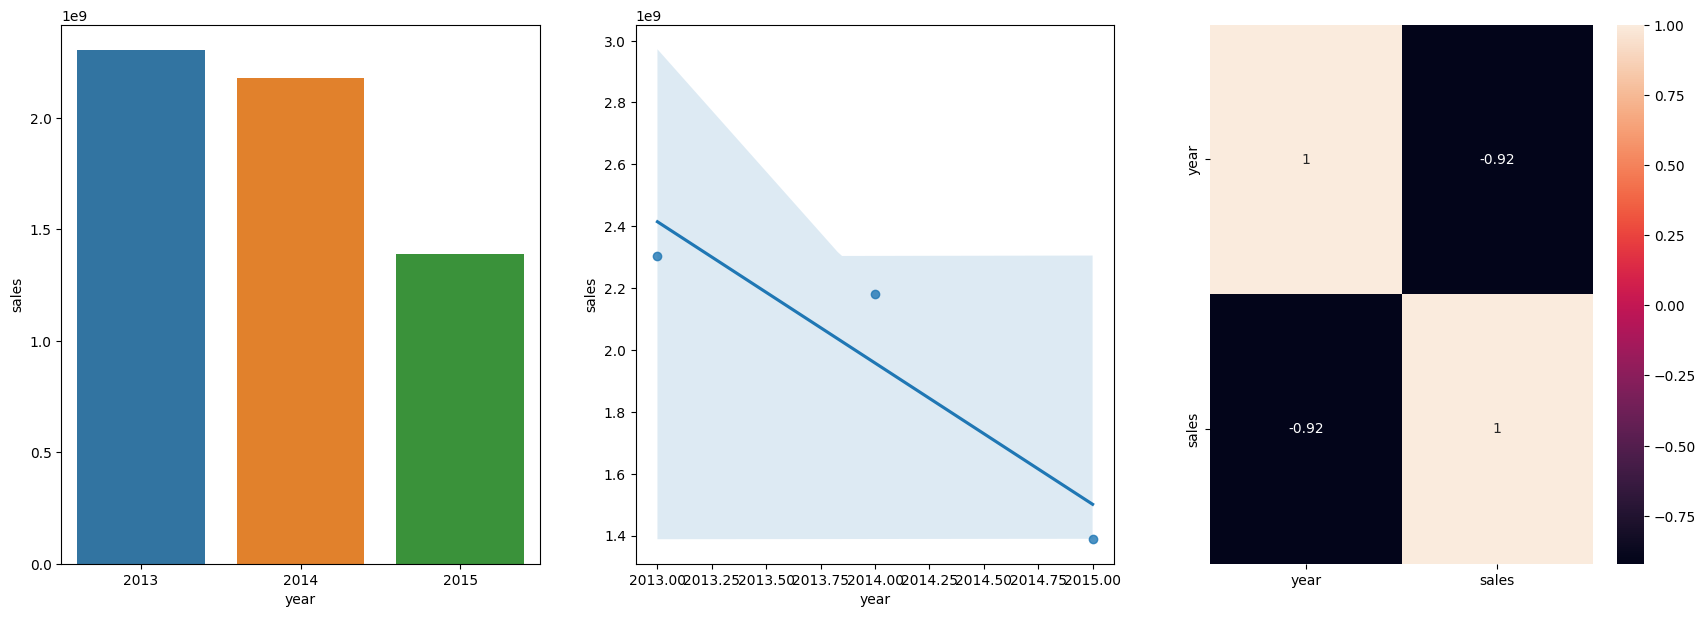

In [56]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

fig=plt.subplots(1,3,figsize=(21,7))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 Lojas deveriam vender mais no segundo semestre do ano

***FALSO***

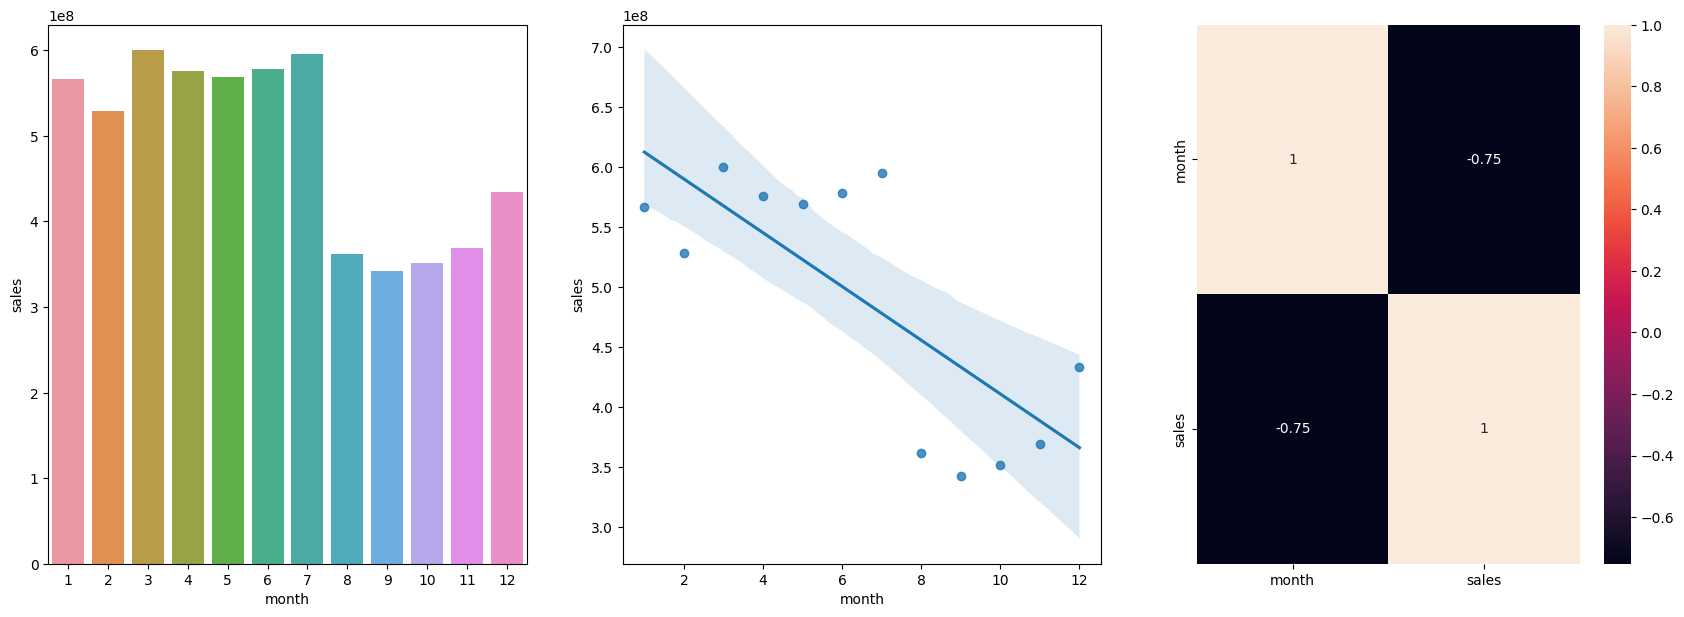

In [57]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

fig=plt.subplots(1,3,figsize=(21,7))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11 Lojas deveriam vender mais depois do dia 10 de cada mês

***VERDADEIRO***

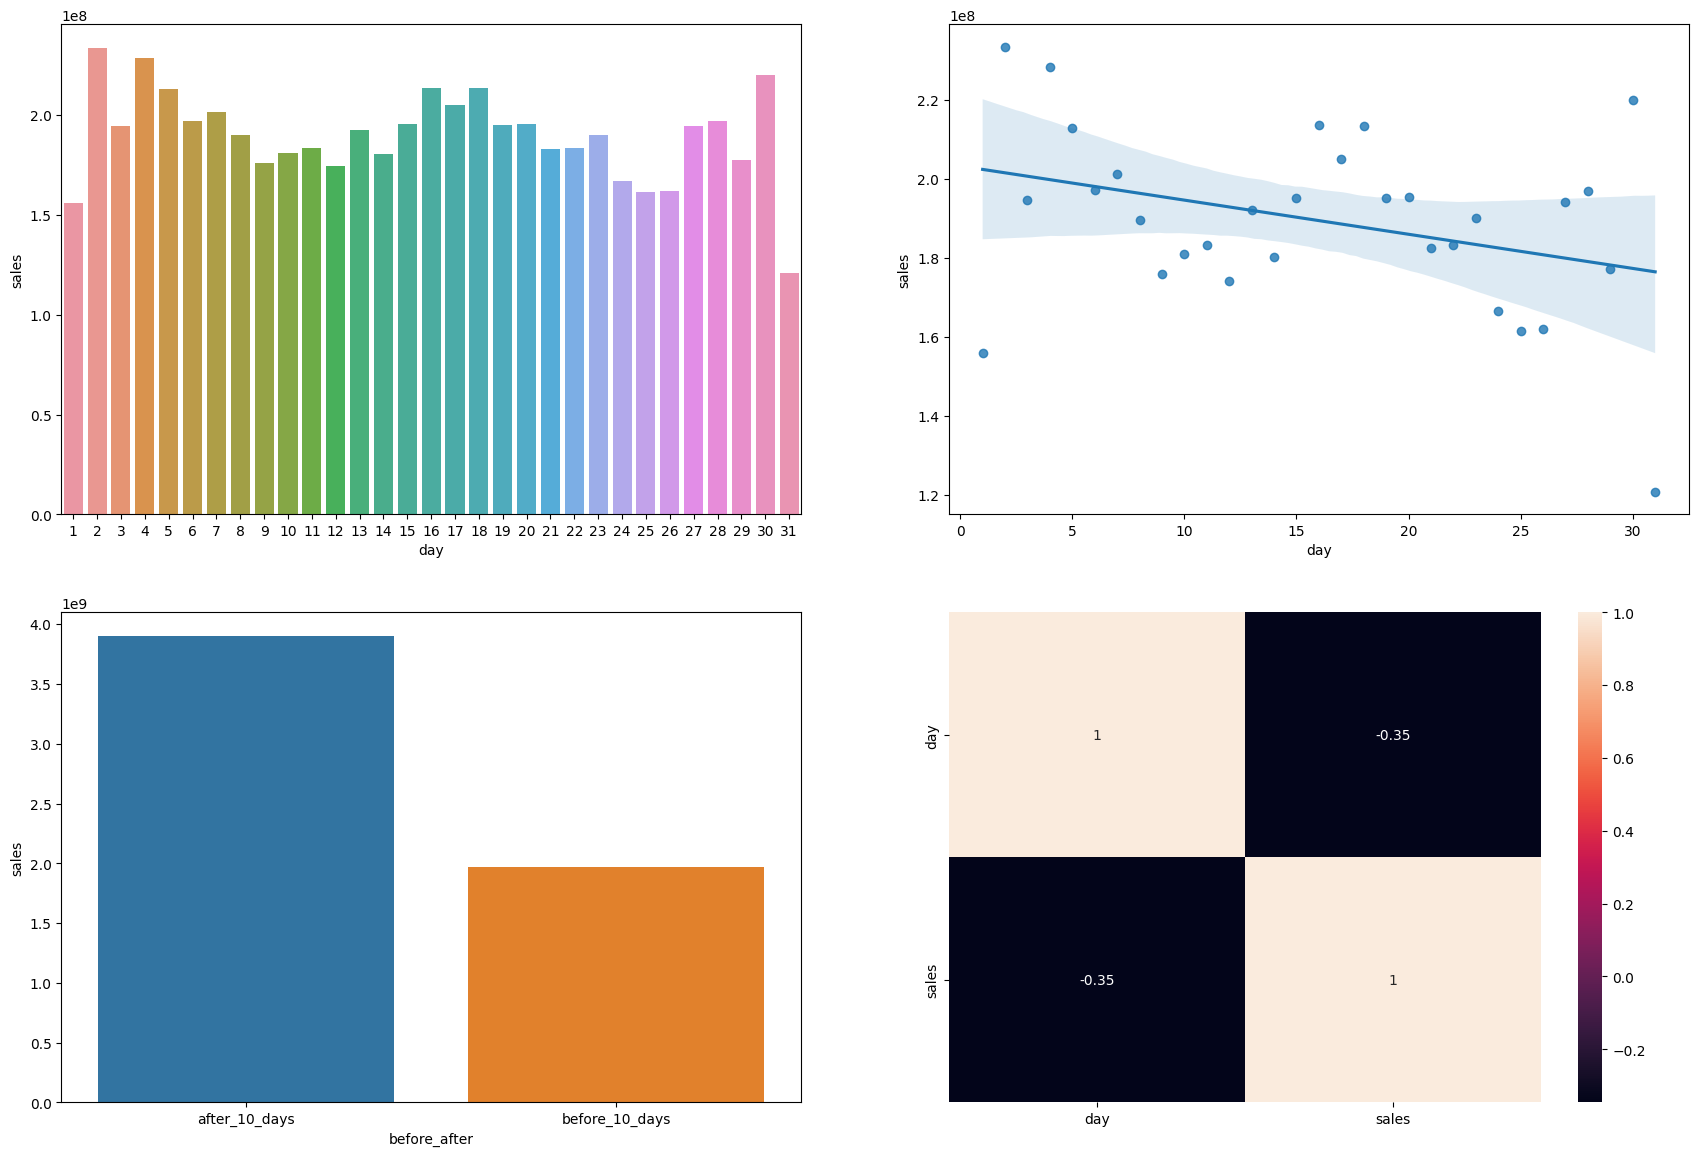

In [58]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

fig=plt.subplots(2,2,figsize=(21,14))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data = aux1);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,3)
sns.barplot(x='before_after', y='sales', data = aux2);


### H12 Lojas deveriam vender menos aos finais de semana

***Verdadeiro***

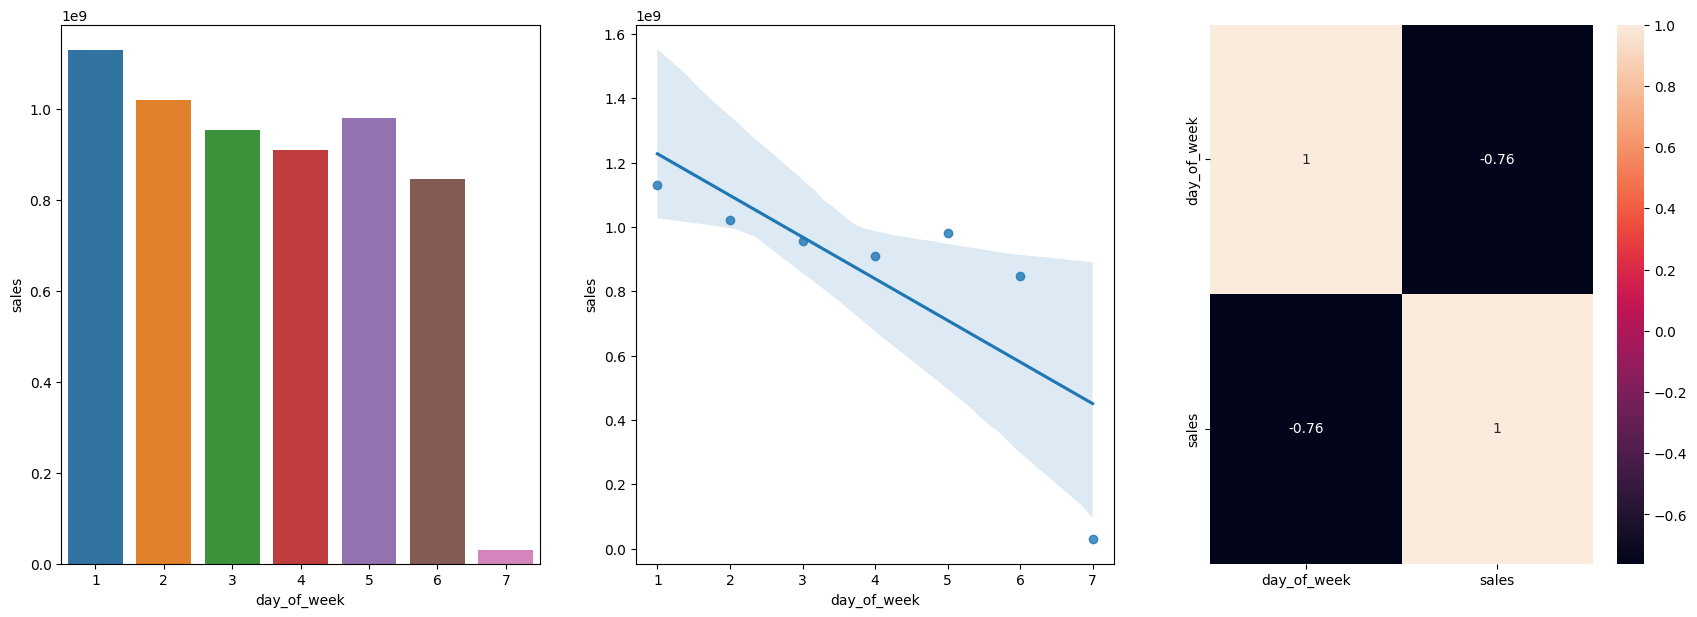

In [59]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

fig=plt.subplots(1,3,figsize=(21,7))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13 Lojas deveriam vender menos durante os feriados escolares.

***Verdadeiro***, Exceto no mês de agosto (provavelmente devido à férias escolares)

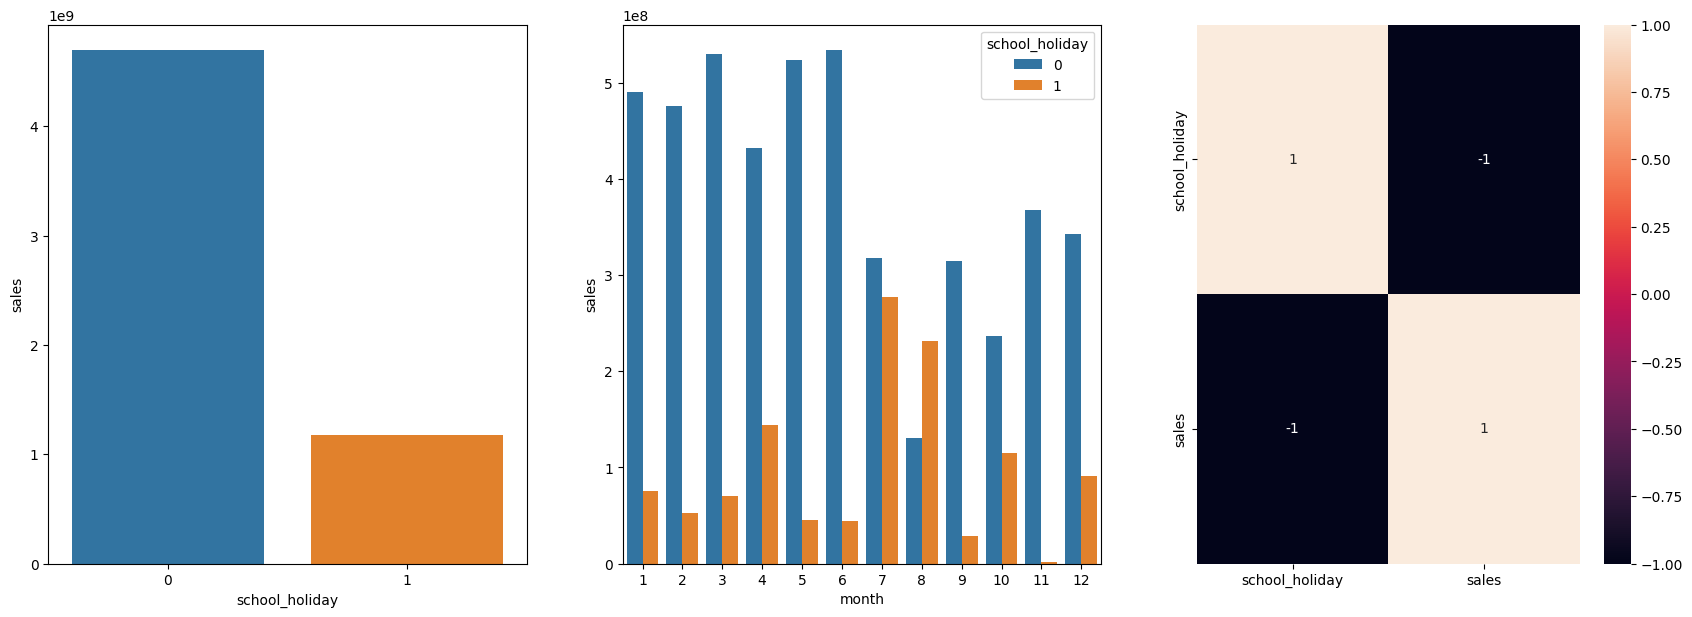

In [60]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday','sales']].groupby(['month', 'school_holiday']).sum().reset_index()

fig=plt.subplots(1,3,figsize=(21,7))

plt.subplot(1,3,1)
sns.barplot(x='school_holiday', y='sales', data = aux1);

plt.subplot(1,3,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data = aux2);

'''plt.subplot(1,3,2)
sns.regplot(x='school_holiday', y='sales', data = aux1);'''

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## 4.3 Analise multivariada
    Analise multivariada, separado pelas variaveis categoricas e núméricas

### Numericas

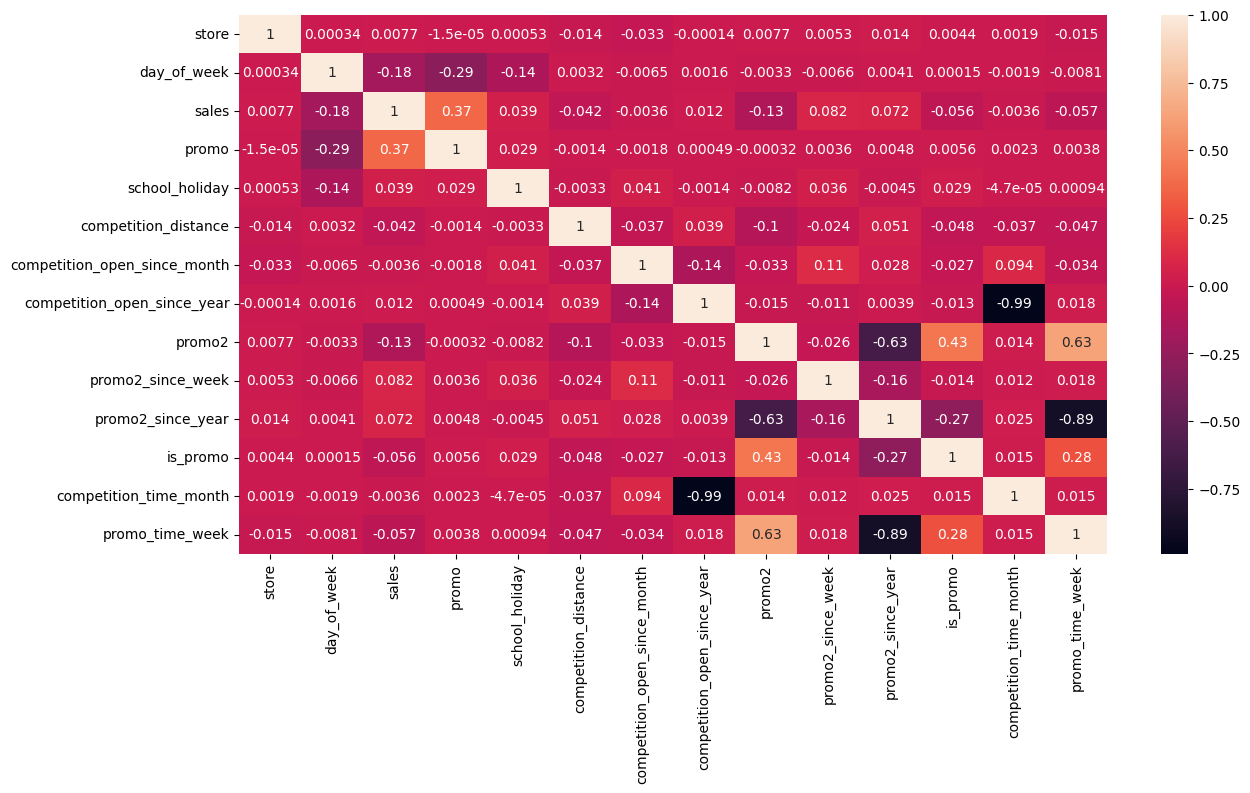

In [61]:
fig = plt.figure(figsize=(14,7))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### categorical

<Axes: >

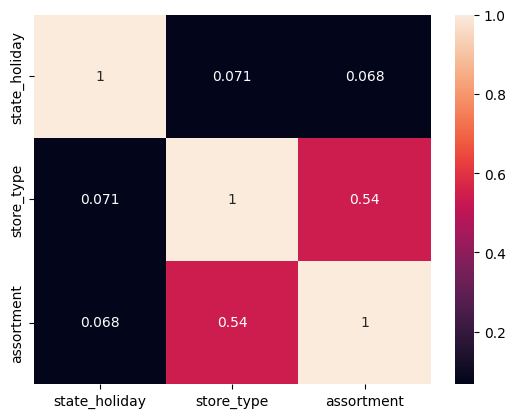

In [62]:


a = cat_attributes

cramer_v(a['state_holiday'],a['store_type'])

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 5.0 PREPARAÇÃO DOS DADOS

In [63]:
df5 = df4.copy()
a = df5.select_dtypes(include=['int32', 'int64', 'float64'])

## 5.1 Normalização


### Nenhuma variavel com distribuição normal
    A normalização funciona bem variaveis que possuem distribuição normal. Como visto na analise univariavel nenhum possue esse tipo de distribuição, portanto não foi aplicado



## 5.2 Rescaling

    Como não temos nenhuma variavel categórica, o método de reescaling foi aplicado. MinMaxScaler foi utilizado para colunas que não apresentam Outliers; quando existe outliers foi aplicado o RobustScaler

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

#sns.boxplot(df5['competition_distance'])
df5['competition_distance']=rs.fit_transform(a[['competition_distance']].values)
pickle.dump(rs, open(os.path.join(PARA_DIR,'competition_distance_scaler.pkl'), 'wb'))

#sns.boxplot(df5['competition_time_month'])
df5['competition_time_month']=rs.fit_transform(a[['competition_time_month']].values)
pickle.dump(rs, open(os.path.join(PARA_DIR,'competition_time_month_scaler.pkl'), 'wb'))


#sns.boxplot(df5['promo_time_week'])
df5['promo_time_week']=mms.fit_transform(a[['promo_time_week']].values)
pickle.dump(mms, open(os.path.join(PARA_DIR,'promo_time_week_scaler.pkl'), 'wb'))

#sns.boxplot(df5['year'])
df5['year']=mms.fit_transform(a[['year']].values)
pickle.dump(mms, open(os.path.join(PARA_DIR,'year_scaler.pkl'), 'wb'))

## 5.3 Transformação

    Nas variaveis categoricas foi aplicado técnicas de transformação, como o onehotencoding, label encoding e ordinal encoding

In [65]:
#state holiday - onehotencoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'], columns=['state_holiday'],dtype=float)

#store_type  Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(os.path.join(PARA_DIR,'store_type_scaler.pkl'), 'wb'))

#store_type  ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


    Para variaveis ciclicas (ano, meses, semanas e dias) foi utilizado uma técnica de escrevelas em sua decomposição em seno e cosseno

In [66]:
#Transformação em variaveis ciclicas

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

    Na variável resposta foi aplicado a transformação mencionada anteriormente 

In [67]:
df5['sales'] = np.log1p(df5['sales'])

# 6.0 SELEÇÃO DE FEATURES
    Nessa seção vamos selecionar as varivaveis de interesse para o modelo. Algumas variaveis que foram utilizadas para definir outras serão automaticamente descartadas (para evitar dependencia linear no modelo). As demais serão escolhidas pelo método do algoritmo Boruta.

## 6.1 Preparação dos dados

In [68]:
df6 = df5.copy()
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

    Separação de treino e teste para utilizar no algoritmo Boruta. Como o objetivo da previsão de vendas é de 6 semanas separamos o conjunto de treino sem as últimas seis semanas.

In [69]:
X_train = df6[df6['date']<'2015-06-19']
y_train = X_train['sales']

X_teste = df6[df6['date']>='2015-06-19']
y_teste = X_teste['sales']


## 6.2 Aplicação Boruta

    A função boruta julga quais variáveis são relevantes para o modelo, de maneira simplificada, ela faz isso verificando como a performance do modelo se comporta ao adicionar uma nova feature.

In [ ]:
X_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=43).fit(X_train_n, y_train_n)

    Armazenamento das variaveis classificadas como boa pelo boruta. Para não ter que rodar o algoritmo boruta toda vez (por ser demorado) preparamos as variaveis selecionadas e as armazenamos manualmente.

In [ ]:
cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop(['date', 'sales'], axis=1)

cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [70]:
cols_selected_boruta_bau = ['store',
                            'promo',
                            'store_type',
                            'assortment',
                            'competition_distance',
                            'competition_open_since_month',
                            'competition_open_since_year',
                            'promo2',
                            'promo2_since_week',
                            'promo2_since_year',
                            'competition_time_month',
                            'promo_time_week',
                            'month_sin',
                            'month_cos',
                            'day_sin',
                            'day_cos',
                            'day_of_week_sin',
                            'day_of_week_cos',
                            'week_of_year_cos',
                            'week_of_year_sin']

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta_bau.copy()
cols_selected_boruta_full.extend(feat_to_add)


# 7 MODELO DE MACHINE LEARGING 

    Com os dados tratados e com as features selecionadas podemos iniciar o processo de ML. Faremos a modelagem apenas com o conjunto de teste e treino, e também utilizando o método de cross-validation.

In [ ]:
x_train = X_train[cols_selected_boruta_bau]
x_teste = X_teste[cols_selected_boruta_bau]
x_training = X_train[cols_selected_boruta_full]


## 7.1 Media

Começamos com o modelo de média, é um dos modelos mais simples, a predição é baseada apenas na média de vendas das loja. Embora simples ele é útil para podermos comparar a performance dos modelos a serem testados em seguida.  

In [ ]:
aux1 = x_teste.copy()
aux1['sales'] = y_teste.copy()

#predict
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average Model', np.expm1(y_teste), np.expm1(yhat_baseline))
baseline_result

## 7.2 Linear regression

Agora utilizamos o modelo de regressão linear. Vemos nos resultados abaixo que temos uma performance pior que o modelo de média, isso indica que nosso conjunto de dados não segue uma distribuição linear e portanto esses tipos de modelo não são os melhores para tentar descreve-los.

In [ ]:
lr = LinearRegression().fit(x_train, y_train)

yhat_lr = lr.predict(x_teste)

lr_result = ml_error( 'LinearRegression', np.expm1(y_teste), np.expm1(yhat_lr))
lr_result

## 7.3 Linear regression - cv

O método de cross-validation nos mostra que o real desempenho da regressão linear é ainda pior do que parecia, pois temos um maior RMSE e um menor R2

In [ ]:
#lr = LinearRegression()
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

## 7.4 Linear Regression regularizado LASSO

Agora aplicamos outro método linear, LASSO, e obtemos mais uma evidência de que métodos lineares não descrevem bem o conjunto de dados que está sendo trabalhado. 

In [ ]:
lrr = Lasso().fit(x_train, y_train)

yhat_lrr = lrr.predict(x_teste)

lrr_result = ml_error( 'LinearRegression - LASSO', np.expm1(y_teste), np.expm1(yhat_lrr))
lrr_result

## 7.5 Linear Regression LASSO - cv

Aplicando o cross-validation só nos reforça o que já foi discutido.

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=True)
lrr_result_cv

## 7.6 Random forest regressor

Partimos agora para os métodos não lineares, começando com a random forest regressor. Podemos notar uma performance muito melhor em comparação aos métodos não lineares e à média.


In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=43).fit(x_train, y_train)

yhat_rf = rf.predict(x_teste)

rf_result = ml_error( 'RFR', np.expm1(y_teste), np.expm1(yhat_rf))
rf_result

## 7.7 Random forest reg - cv


Ao aplicar o cross-validation no random forest vemos que seu desempenho diminui, mas se mantém alto, se mostrando uma boa opção para ser utilizado.

In [ ]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

## 7.8 XGBoost Regressor

O XGBoost também apresenta um bom desempenho.

In [ ]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror').fit(x_train, y_train)

yhat_xgb = model_xgb.predict(x_teste)

xgb_result = ml_error( 'xgboost', np.expm1(y_teste), np.expm1(yhat_xgb))
xgb_result

## 7.9 XGBoost Reg - cv

O desempenho do XGB é confirmado ao aplicar o cross validation, embora não seja tão bom quanto ao random forest regressor ele entrega desempenho próximo e com menos tempo de processamento.

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGB Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.10 Comparações de performance

A seguir temos as classificações dos algoritmos baseada no RMSE. Vemos que a random forest regressor é a que apresenta um RMSE mais baixo, seguida pelo xgboost por uma diferença próxima a 200, a principio o idela seria continuar com a RFR, porém como já comentado, o XGBoost apresenta um desempenho semelhante com um tempo de processamento bem menor (6x menor comparado com o RFR), portanto seguiremos com ele.

### 7.10.1 Comparação para os resultados sem cross-validation

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.10.2 Comparações para os resultados com cross-validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

# 8.0 HYPERPARAMETER FINE TUNING

Após ter escolhido o modelo, é necessário refina-lo para obter resultados ainda melhores. A técnia utilizada aqui foi a Random Search onde, manualmente, alteramos os parametros do modelo escolhido e consideramos aquele que apresenta a melhor performance. Antes de calcular a eficiência dos modelos as váriavéis resposta foram transformadas de volta através da função exponêncial.

## 8.1 Random Search

    Valores aleatórios para os parametros do XGBoost

In [ ]:
param = {'n_est': [500, 1000, 1500, 2000],
         'eta': [0.1, 0.2, 0.3],
         'max_depth': [4, 6, 8, 10, 12],
         'subsample': [1, 0.8, 0.6],
         'colsample_bytree': [1, 0.8, 0.6],
         'min_child_weight': [1, 6, 11]}

MAX_EVAL = 10

    Teste aleatório desses valores

In [ ]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators = hp['n_est'],
                                 eta = hp['eta'],
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    

    result = cross_validation( x_training, 5, 'XGB', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result



## 8.2 Final model

Após realizar vários ajustes de maneira aleatória pegamos os parametros que apresentaram melhor performance e treinamos o modelo final.

In [ ]:
param_tuned = {'n_est': 500,
               'eta': 0.1,
               'max_depth': 12,
               'subsample': 1,
               'colsample_bytree': 1,
               'min_child_weight': 1}


In [ ]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators = param_tuned['n_est'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
pickle.dump(model_xgb_tuned, open(os.path.join(BASE_DIR,'model/model_rossman.pkl'), 'wb'))
    
yhat_tuned = model_xgb_tuned.predict(x_teste)

result_tuned = ml_error('XGB', np.expm1(y_teste), np.expm1(yhat_tuned))


result_tuned

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [ ]:
df9 = X_teste[cols_selected_boruta_full].copy()
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_tuned)

## 9.1 Business performance

In [ ]:
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')

df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on='store')
df9_2


#Pior cenario
df9_2['worst_scenario'] = df9_2['predictions']-df9_2['MAE'] 
df9_2['best_scenario'] = df9_2['predictions']+df9_2['MAE'] 

df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df9_2.sort_values('MAPE',ascending=False)

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df9_2)

In [ ]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df9_3['Values'] = df9_3['Values'].map('${:,.2f}'.format)
df9_3

In [ ]:
df9['error'] = df9['sales']- df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

fig = plt.subplots(2,2,figsize=(21,14))

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)


plt.subplot(2,2,3)
sns.histplot(df9['error'], kde=True, stat="density");

plt.subplot(2,2,4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# 10.0 DEPLOY

In [ ]:
df10 = pd.read_csv('/home/mayconr/repos/ComunidadeDS/dsproducao/rossmann_project/data/test.csv')

df_test = pd.merge(df10, df_store_raw, how= 'left', on= 'Store')

df_test = df_test[df_test['Store'].isin([40, 33, 81])]

df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test['Open'].isnull()]

df_test = df_test.drop('Id', axis=1)



## 10.1 Servidor local

In [ ]:
data = json.dumps(df_test.to_dict(orient='records'))
url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type': 'application/json'} 

r = requests.post(url, data=data, headers=header)
print('Status Code{}'.format(r.status_code))

## 10.2 Servidor online

In [ ]:

url = 'https://rossmann-web-app.onrender.com/rossmann/predict'

header = {'Content-type': 'application/json'} 

r = requests.post(url, data=data, headers=header)
print('Status Code{}'.format(r.status_code))

## Utilizando a API

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 =d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Sotre number {} will sell ${:,.2f} in the next 6 weeks'. format(d2.loc[i,'store'], d2.loc[i,'prediction']))
